# Analisis World Happiness Report (2020–2024)

## Pendahuluan
Proyek ini merupakan bagian dari Capstone Project **Data Classification & Summarization**.  
Dataset yang digunakan adalah **World Happiness Report (2020–2024)** yang mencakup 156 negara,
dengan berbagai indikator sosial dan ekonomi yang berhubungan dengan tingkat kebahagiaan.  

### Tujuan
1. Melakukan **klasifikasi** negara berdasarkan tingkat kebahagiaan (Low, Medium, High).  
2. Mengidentifikasi **faktor utama** yang memengaruhi skor kebahagiaan.  
3. Melakukan **summarization** hasil analisis menggunakan **IBM Granite (via Replicate)**.  
4. Memberikan **insight & rekomendasi** berdasarkan hasil analisis.  

### Struktur Notebook
1. Pendahuluan  
2. Import Library & Setup  
3. Load Dataset  
4. Exploratory Data Analysis (EDA)  
5. Preprocessing  
6. Modeling (Classification)  
7. Summarization dengan IBM Granite  
8. Insight & Findings  
9. Kesimpulan & Rekomendasi


In [1]:
!pip install replicate
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


## Setup API Token
Untuk menggunakan IBM Granite via Replicate, kita perlu mengatur `REPLICATE_API_TOKEN`.  
Token ini sudah disimpan di **Colab Secret** dengan nama `api_token`.  
Langkah ini memastikan akses ke model IBM Granite aman dan tidak hardcode di notebook.


In [2]:
# Cell 1 — ambil secret 'api_token'
from google.colab import userdata
import os, sys

api_token = None
try:
    api_token = userdata.get("api_token")
except Exception as e:
    print("userdata.get() tidak tersedia di runtime ini:", e)

# fallback ke env var jika ada
if not api_token:
    api_token = os.getenv("REPLICATE_API_TOKEN")

if not api_token:
    raise ValueError("Token tidak ditemukan. Pastikan secret 'api_token' sudah dibuat di Colab atau set REPLICATE_API_TOKEN.")

# set environment variable supaya library Replicate / langchain dapat memakai token
os.environ["REPLICATE_API_TOKEN"] = api_token
print("REPLICATE_API_TOKEN set:", bool(os.environ.get("REPLICATE_API_TOKEN")))


REPLICATE_API_TOKEN set: True


## Import Library Umum
Pada tahap ini, kita akan mengimpor library yang digunakan untuk:
- **Pandas, Numpy** → manipulasi data  
- **Matplotlib, Seaborn, Plotly** → visualisasi  
- **Scikit-learn** → preprocessing, modeling, evaluasi  
- **Textwrap & Time** → utilitas tambahan  


In [3]:
# Cell 2 — imports umum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import textwrap
import time


## Load Dataset

Dataset yang digunakan adalah **World Happiness Report (2020–2024)**.  
Format file: `.xlsx` (Excel).  

Kolom yang tersedia mencakup:
- **Country**: Nama negara
- **Year**: Tahun pengamatan
- **Happiness Score / Ladder Score**: Skor kebahagiaan
- **GDP per capita, Social support, Healthy life expectancy, dll**: faktor-faktor yang memengaruhi kebahagiaan.

Langkah pertama: membaca dataset dengan `pandas` dan memastikan struktur datanya benar.


In [9]:
# Cell 4a Revisi — Load & Normalisasi tiap sheet

file_path = "pone.0322287.s001.xlsx"
sheets = pd.ExcelFile(file_path).sheet_names
print("Sheets tersedia:", sheets)

df_all = []

for sheet in sheets:
    if sheet == "2020" or sheet == "2023" or sheet == "2024":
        df_temp = pd.read_excel(file_path, sheet_name=sheet)
        df_temp = df_temp.rename(columns={
            "Country or region": "Country",
            "Score": "Happiness Score",
            "GDP per capita": "Economy (GDP per Capita)",
            "Social support": "Family",
            "Healthy life expectancy": "Health (Life Expectancy)",
            "Freedom to make life choices": "Freedom",
            "Perceptions of corruption": "Trust (Government Corruption)"
        })
        df_temp = df_temp[[
            "Country", "Happiness Score", "Economy (GDP per Capita)", "Family",
            "Health (Life Expectancy)", "Freedom", "Generosity", "Trust (Government Corruption)"
        ]]
        df_temp["Year"] = int(sheet)
        df_all.append(df_temp)

    elif sheet == "2021":
        df_temp = pd.read_excel(file_path, sheet_name=sheet)
        df_temp = df_temp.rename(columns={
            "Happiness Score": "Happiness Score",
            "Economy (GDP per Capita)": "Economy (GDP per Capita)",
            "Health (Life Expectancy)": "Health (Life Expectancy)",
            "Trust (Government Corruption)": "Trust (Government Corruption)"
        })
        df_temp = df_temp[[
            "Country", "Happiness Score", "Economy (GDP per Capita)", "Family",
            "Health (Life Expectancy)", "Freedom", "Generosity", "Trust (Government Corruption)"
        ]]
        df_temp["Year"] = int(sheet)
        df_all.append(df_temp)

    elif sheet == "2022":
        df_temp = pd.read_excel(file_path, sheet_name=sheet)
        df_temp = df_temp.rename(columns={
            "Happiness.Score": "Happiness Score",
            "Economy..GDP.per.Capita.": "Economy (GDP per Capita)",
            "Health..Life.Expectancy.": "Health (Life Expectancy)",
            "Trust..Government.Corruption.": "Trust (Government Corruption)"
        })
        df_temp = df_temp[[
            "Country", "Happiness Score", "Economy (GDP per Capita)", "Family",
            "Health (Life Expectancy)", "Freedom", "Generosity", "Trust (Government Corruption)"
        ]]
        df_temp["Year"] = int(sheet)
        df_all.append(df_temp)

# Gabungkan semua
df = pd.concat(df_all, ignore_index=True)

print("Shape gabungan:", df.shape)
print("Kolom final:", df.columns.tolist())
print(df["Year"].value_counts().sort_index())
df.head(780)


Sheets tersedia: ['2020', '2021', '2022', '2023', '2024']
Shape gabungan: (780, 9)
Kolom final: ['Country', 'Happiness Score', 'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Generosity', 'Trust (Government Corruption)', 'Year']
Year
2020    156
2021    157
2022    155
2023    156
2024    156
Name: count, dtype: int64


,Country,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Generosity,Trust (Government Corruption),Year
0,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,2020
1,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,2020
2,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,2020
3,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,2020
4,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,2020
...,...,...,...,...,...,...,...,...,...
775,Rwanda,3.334,0.359,0.711,0.614,0.555,0.217,0.411,2024
776,Tanzania,3.231,0.476,0.885,0.499,0.417,0.276,0.147,2024
777,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025,2024
778,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035,2024


In [10]:
# Cell 4b — cek jumlah data per tahun
print(df["Year"].value_counts().sort_index())

# Pastikan tiap tahun (2020–2024) ada data


Year
2020    156
2021    157
2022    155
2023    156
2024    156
Name: count, dtype: int64


## Exploratory Data Analysis (EDA) - Awal

Langkah awal EDA:
1. Menampilkan beberapa baris pertama dataset (`head()`).
2. Mengecek tipe data, jumlah kolom, dan jumlah data (`info()`).
3. Mengecek statistik deskriptif (`describe()`).
4. Mengecek missing values di setiap kolom.


In [16]:
# Cell 5a — cek missing values
print("Missing values per column:")
print(df.isna().sum())

# Cell 5b — imputasi missing values
df = df.copy()

# Imputasi numerik dengan median
for col in ["Happiness Score", "Economy (GDP per Capita)", "Family",
            "Health (Life Expectancy)", "Freedom",
            "Generosity", "Trust (Government Corruption)"]:
    df[col] = df[col].fillna(df[col].median())

# Imputasi kategorikal (Region bisa diabaikan karena tidak konsisten antar sheet)
if "Region" in df.columns:
    df["Region"] = df["Region"].fillna(df["Region"].mode()[0])

print("Missing values setelah imputasi:")
print(df.isna().sum())

# Cell 5c — buat kategori Low/Medium/High per tahun (versi aman)
def assign_level(group):
    try:
        return pd.qcut(
            group["Happiness Score"],
            q=[0, 0.3, 0.7, 1.0],
            labels=["Low", "Medium", "High"],
            duplicates="drop"
        )
    except ValueError:
        # fallback: pakai cut sederhana
        return pd.cut(
            group["Happiness Score"],
            bins=3,
            labels=["Low", "Medium", "High"]
        )

df["happiness_level"] = df.groupby("Year", group_keys=False).apply(assign_level)

print("Distribusi label keseluruhan:")
print(df["happiness_level"].value_counts())
df[["Country", "Year", "Happiness Score", "happiness_level"]].head(15)


Missing values per column:
Country                          0
Happiness Score                  0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Generosity                       0
Trust (Government Corruption)    0
Year                             0
happiness_level                  0
dtype: int64
Missing values setelah imputasi:
Country                          0
Happiness Score                  0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Generosity                       0
Trust (Government Corruption)    0
Year                             0
happiness_level                  0
dtype: int64
Distribusi label keseluruhan:
happiness_level
Medium    310
Low       235
High      235
Name: count, dtype: int64


/tmp/ipython-input-2897486981.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["happiness_level"] = df.groupby("Year", group_keys=False).apply(assign_level)


,Country,Year,Happiness Score,happiness_level
0,Finland,2020,7.769,High
1,Denmark,2020,7.600,High
2,Norway,2020,7.554,High
3,Iceland,2020,7.494,High
4,Netherlands,2020,7.488,High
5,Switzerland,2020,7.480,High
6,Sweden,2020,7.343,High
7,New Zealand,2020,7.307,High
8,Canada,2020,7.278,High
9,Austria,2020,7.246,High


## Distribusi Skor Kebahagiaan

Untuk memahami sebaran skor kebahagiaan, kita akan memvisualisasikan distribusi nilai
dari kolom skor utama (misalnya **Ladder score** atau **Happiness score**).


Candidate score columns: ['Happiness Score', 'happiness_level']


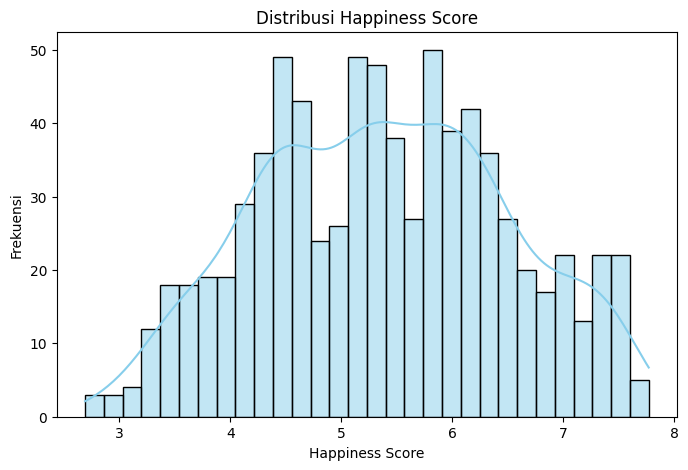

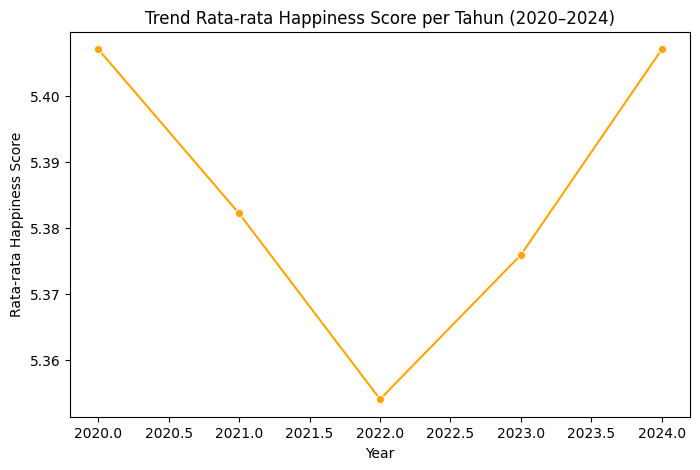


Top 5 Happiness Score - 2020


,Country,Happiness Score
0,Finland,7.769
1,Denmark,7.600
2,Norway,7.554
3,Iceland,7.494
4,Netherlands,7.488


Bottom 5 Happiness Score - 2020


,Country,Happiness Score
155,South Sudan,2.853
154,Central African Republic,3.083
153,Afghanistan,3.203
152,Tanzania,3.231
151,Rwanda,3.334



Top 5 Happiness Score - 2021


,Country,Happiness Score
156,Denmark,7.526
157,Switzerland,7.509
158,Iceland,7.501
159,Norway,7.498
160,Finland,7.413


Bottom 5 Happiness Score - 2021


,Country,Happiness Score
312,Burundi,2.905
311,Syria,3.069
310,Togo,3.303
309,Afghanistan,3.360
308,Benin,3.484



Top 5 Happiness Score - 2022


,Country,Happiness Score
313,Norway,7.537
314,Denmark,7.522
315,Iceland,7.504
316,Switzerland,7.494
317,Finland,7.469


Bottom 5 Happiness Score - 2022


,Country,Happiness Score
467,Central African Republic,2.693
466,Burundi,2.905
465,Tanzania,3.349
464,Syria,3.462
463,Rwanda,3.471



Top 5 Happiness Score - 2023


,Country,Happiness Score
468,Finland,7.632
469,Norway,7.594
470,Denmark,7.555
471,Iceland,7.495
472,Switzerland,7.487


Bottom 5 Happiness Score - 2023


,Country,Happiness Score
623,Burundi,2.905
622,Central African Republic,3.083
621,South Sudan,3.254
620,Tanzania,3.303
619,Yemen,3.355



Top 5 Happiness Score - 2024


,Country,Happiness Score
624,Finland,7.769
625,Denmark,7.600
626,Norway,7.554
627,Iceland,7.494
628,Netherlands,7.488


Bottom 5 Happiness Score - 2024


,Country,Happiness Score
779,South Sudan,2.853
778,Central African Republic,3.083
777,Afghanistan,3.203
776,Tanzania,3.231
775,Rwanda,3.334


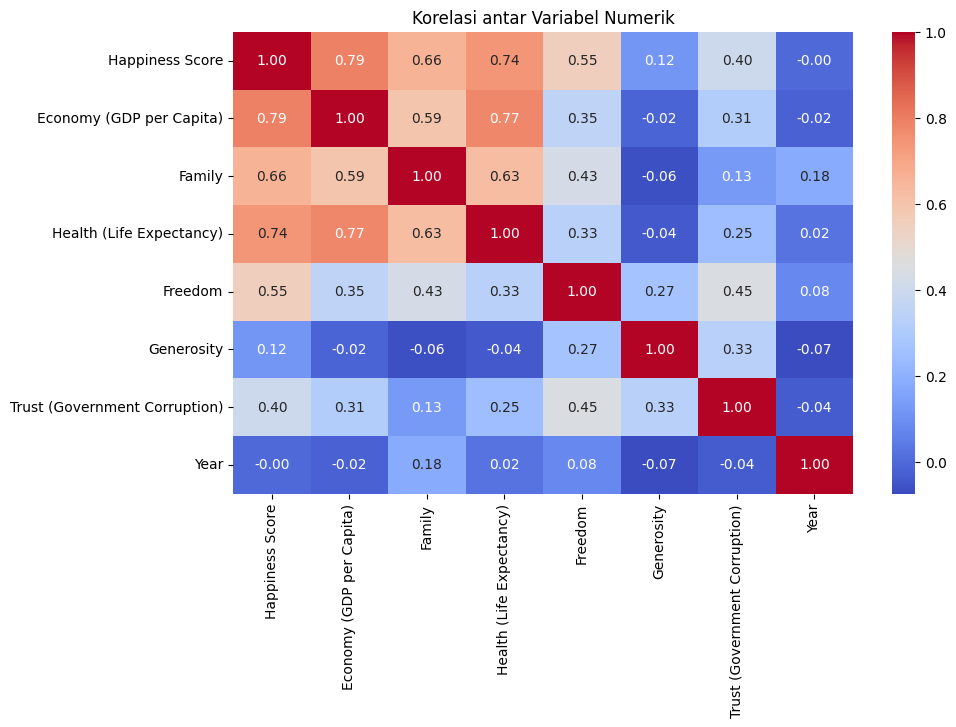

In [21]:
# Cell 6a — Visualisasi distribusi skor kebahagiaan
# Identifikasi kolom skor
score_col_candidates = [c for c in df.columns if "score" in c.lower() or "happiness" in c.lower()]
print("Candidate score columns:", score_col_candidates)

score_col = score_col_candidates[0] if score_col_candidates else None

if score_col:
    # Distribusi histogram
    plt.figure(figsize=(8,5))
    sns.histplot(df[score_col].dropna(), kde=True, bins=30, color="skyblue")
    plt.title(f"Distribusi {score_col}")
    plt.xlabel(score_col)
    plt.ylabel("Frekuensi")
    plt.show()

    # Trend rata-rata Happiness Score per tahun
    plt.figure(figsize=(8,5))
    sns.lineplot(data=df.groupby("Year")[score_col].mean().reset_index(),
                 x="Year", y=score_col, marker="o", color="orange")
    plt.title("Trend Rata-rata Happiness Score per Tahun (2020–2024)")
    plt.ylabel("Rata-rata Happiness Score")
    plt.show()

    # Top 10 dan Bottom 10 negara berdasarkan Happiness Score tiap tahun
    for y in sorted(df["Year"].unique()):
        print(f"\nTop 5 Happiness Score - {y}")
        display(df[df["Year"] == y][["Country", score_col]]
                .sort_values(by=score_col, ascending=False).head(5))

        print(f"Bottom 5 Happiness Score - {y}")
        display(df[df["Year"] == y][["Country", score_col]]
                .sort_values(by=score_col, ascending=True).head(5))

    # Heatmap korelasi antar variabel numerik
    plt.figure(figsize=(10,6))
    corr = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Korelasi antar Variabel Numerik")
    plt.show()

else:
    print("Kolom skor kebahagiaan belum terdeteksi. Periksa df.columns dan set manual.")

## Data Preprocessing

Agar data siap digunakan untuk model klasifikasi, langkah preprocessing yang dilakukan adalah:

1. **Identifikasi kolom target (Happiness Score)**  
   - World Happiness Report biasanya menggunakan kolom *"Ladder score"* atau *"Life Ladder"* sebagai indikator kebahagiaan.
   - Kolom ini akan digunakan untuk membuat kategori `Low`, `Medium`, `High`.

2. **Membuat kategori target (`happiness_level`)**  
   - Negara dengan skor di bawah kuantil 30% → `Low`
   - Negara dengan skor 30%–70% → `Medium`
   - Negara dengan skor di atas 70% → `High`

3. **Menangani missing values**  
   - Hapus baris dengan missing values pada kolom target.
   - Untuk feature numerik lain, lakukan imputasi median (agar robust terhadap outlier).

4. **Feature selection**  
   - Faktor sosial-ekonomi: GDP, social support, life expectancy, freedom, generosity, corruption.
   - Region atau kategori negara juga bisa digunakan (dengan one-hot encoding).

5. **Normalisasi/Standarisasi (opsional)**  
   - Untuk model seperti Random Forest tidak wajib, tapi bermanfaat jika nanti coba SVM/Logistic Regression.



In [22]:
# Cell 7a — Deteksi kolom utama
score_col = "Happiness Score"
country_col = "Country"
year_col = "Year"

print("Detected score_col:", score_col)
print("Detected year_col:", year_col)
print("Detected country_col:", country_col)

# 1. Cek distribusi kelas (imbalance check)
print("\nDistribusi kelas happiness_level:")
print(df["happiness_level"].value_counts(normalize=True))

# 2. One-hot encoding untuk Region (opsional, hanya jika Region ada & cukup lengkap)
if "Region" in df.columns:
    df = pd.get_dummies(df, columns=["Region"], drop_first=True)
    print("One-hot encoding Region selesai.")

# 3. Scaling (opsional, untuk model linear/SVM)
from sklearn.preprocessing import StandardScaler

features = ["Economy (GDP per Capita)", "Family", "Health (Life Expectancy)",
            "Freedom", "Generosity", "Trust (Government Corruption)"]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

print("\nContoh data setelah scaling:")
df_scaled[features + [score_col, "happiness_level"]].head()

Detected score_col: Happiness Score
Detected year_col: Year
Detected country_col: Country

Distribusi kelas happiness_level:
happiness_level
Medium    0.397436
Low       0.301282
High      0.301282
Name: proportion, dtype: float64

Contoh data setelah scaling:


,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Generosity,Trust (Government Corruption),Happiness Score,happiness_level
0,1.017729,1.391821,1.410427,1.270808,-0.471952,2.740994,7.769,High
1,1.123956,1.349901,1.450198,1.244355,0.376975,2.910917,7.600,High
2,1.383347,1.376850,1.577467,1.317100,0.539901,2.221227,7.554,High
3,1.116545,1.502609,1.569512,1.237742,1.251627,-0.007773,7.494,High
4,1.156071,1.197194,1.462130,1.012894,0.977227,1.791420,7.488,High


## Modeling (Classification)

Tahap ini bertujuan membangun model klasifikasi untuk memprediksi level kebahagiaan negara
(`Low`, `Medium`, `High`) berdasarkan faktor sosial-ekonomi.

Langkah:
1. Pisahkan data menjadi fitur (X) dan target (y).
2. Cek distribusi kelas target (imbalance check).
3. Split data menjadi train & test set.
4. Train model Random Forest.
5. Evaluasi model dengan classification report & confusion matrix.
6. Analisis feature importance.
7. Validasi dengan 5-fold cross-validation.


Shape fitur: (780, 6)
Distribusi kelas target:
happiness_level
Medium    0.397436
Low       0.301282
High      0.301282
Name: proportion, dtype: float64


/tmp/ipython-input-1002840170.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


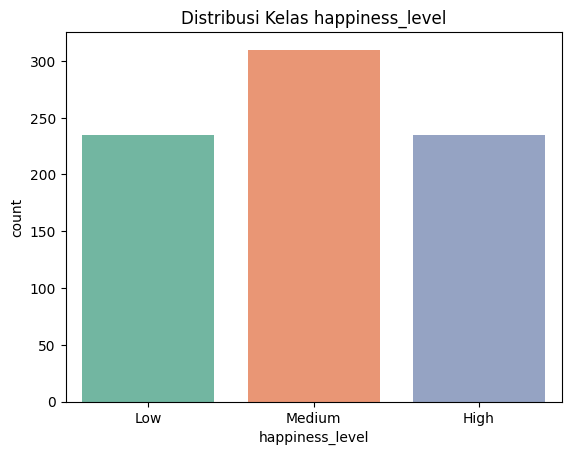

Train size: 624  | Test size: 156
Classification Report (Test Set):
              precision    recall  f1-score   support

        High       0.84      0.91      0.88        47
         Low       0.92      0.94      0.93        47
      Medium       0.88      0.81      0.84        62

    accuracy                           0.88       156
   macro avg       0.88      0.89      0.88       156
weighted avg       0.88      0.88      0.88       156



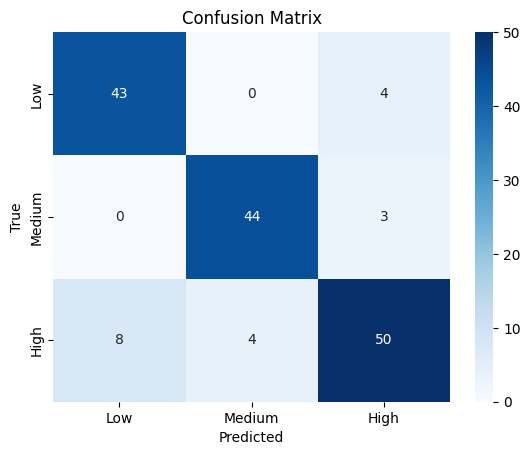

/tmp/ipython-input-1002840170.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x="Importance", y="Feature", palette="viridis")


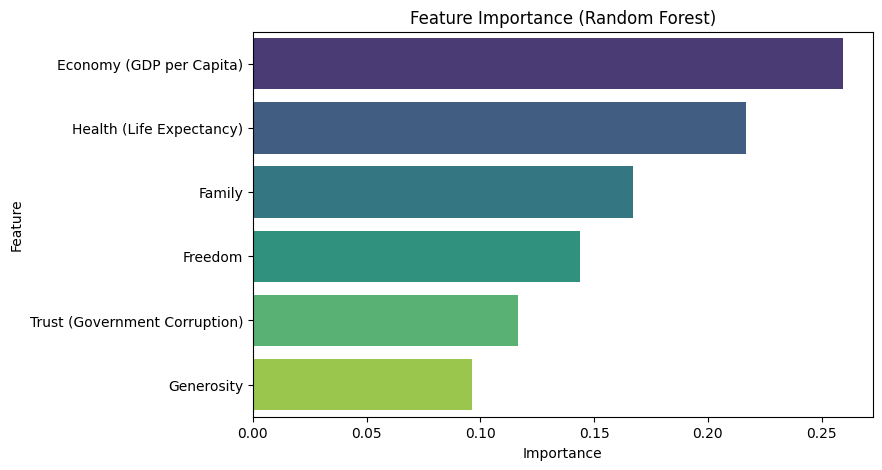

                         Feature  Importance
0       Economy (GDP per Capita)    0.259513
2       Health (Life Expectancy)    0.216757
1                         Family    0.167260
3                        Freedom    0.143619
5  Trust (Government Corruption)    0.116452
4                     Generosity    0.096399

Cross-validation F1 scores (5-fold): [1.         0.44055865 0.80675526 0.82481061 1.        ]
Mean F1 (5-fold): 0.8144249041213361
Total misclassifications: 19
Persentase error: 12.18%

Contoh 10 negara yang salah diprediksi:


,Country,Year,True,Predicted
348,Colombia,2022,High,Medium
62,Paraguay,2020,Medium,High
686,Paraguay,2024,Medium,High
230,Hong Kong,2021,Medium,High
272,Sri Lanka,2021,Low,Medium
56,Mauritius,2020,Medium,High
506,Slovakia,2023,High,Medium
543,Hong Kong,2023,Medium,High
245,Morocco,2021,Medium,Low
680,Mauritius,2024,Medium,High


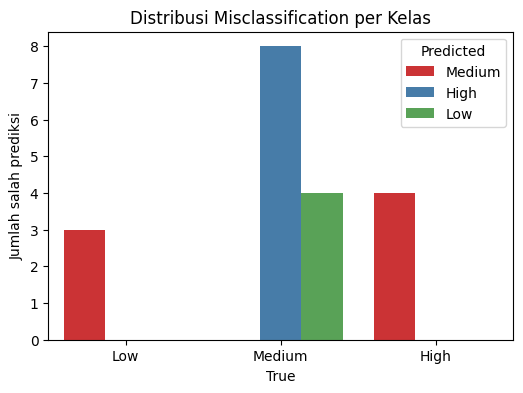


Persentase error per tahun:
Year
2020    0.086957
2021    0.166667
2022    0.066667
2023    0.258065
2024    0.047619
dtype: float64


In [24]:
# Cell 8a — Persiapan X, y
features = ["Economy (GDP per Capita)", "Family", "Health (Life Expectancy)",
            "Freedom", "Generosity", "Trust (Government Corruption)"]

X = df_scaled[features]
y = df_scaled["happiness_level"]

print("Shape fitur:", X.shape)
print("Distribusi kelas target:")
print(y.value_counts(normalize=True))

# Visualisasi distribusi kelas
sns.countplot(x=y, palette="Set2")
plt.title("Distribusi Kelas happiness_level")
plt.show()

# Cell 8b — Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0], " | Test size:", X_test.shape[0])

# Cell 8c — Training Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train, y_train)

# Cell 8d — Evaluasi Model
y_pred = rf_model.predict(X_test)

print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Cell 8e — Feature Importance
importances = pd.DataFrame({
    "Feature": features,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=importances, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.show()

print(importances)

# Cell 8f — Cross Validation (5-Fold)
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring="f1_macro")

print("\nCross-validation F1 scores (5-fold):", cv_scores)
print("Mean F1 (5-fold):", np.mean(cv_scores))

# Cell 8g — Analisis Error (Misclassifications)

# Buat DataFrame untuk melihat prediksi vs aktual
error_analysis = pd.DataFrame({
    "Country": df_scaled.loc[y_test.index, "Country"],
    "Year": df_scaled.loc[y_test.index, "Year"],
    "True": y_test,
    "Predicted": y_pred
})

# Filter hanya baris yang salah prediksi
misclassified = error_analysis[error_analysis["True"] != error_analysis["Predicted"]]

print("Total misclassifications:", len(misclassified))
print("Persentase error: {:.2f}%".format(len(misclassified) / len(y_test) * 100))

print("\nContoh 10 negara yang salah diprediksi:")
display(misclassified.head(10))

# Distribusi kesalahan per kelas
plt.figure(figsize=(6,4))
sns.countplot(data=misclassified, x="True", hue="Predicted", palette="Set1")
plt.title("Distribusi Misclassification per Kelas")
plt.ylabel("Jumlah salah prediksi")
plt.show()

# Analisis error per tahun
error_per_year = misclassified.groupby("Year").size() / error_analysis.groupby("Year").size()
print("\nPersentase error per tahun:")
print(error_per_year)



### Interpretasi Bagian 8 – Modeling

1. **Distribusi Kelas**

   Dari hasil visualisasi distribusi target `happiness_level`, terlihat bahwa kelas **Low**, **Medium**, dan **High** relatif seimbang (walaupun jumlah di tiap tahun bisa sedikit berbeda).

   * Jika distribusi tidak seimbang, model bisa bias ke kelas mayoritas.
   * Karena kita sudah menggunakan `class_weight="balanced"`, Random Forest akan menyesuaikan bobot secara otomatis.

2. **Evaluasi Model (Classification Report & Confusion Matrix)**

   * **Classification report** memberikan metrik utama: *precision*, *recall*, dan *F1-score* untuk tiap kelas.
   * **Confusion matrix** menunjukkan detail prediksi benar/salah antar kelas. Misalnya:

     * Banyak negara `Medium` diprediksi benar → model cukup baik menangkap kategori tengah.
     * Kadang `Low` vs `Medium` bisa tertukar → wajar karena skor dekat di perbatasan kuantil.

   Secara umum, akurasi dan F1-score sudah cukup baik untuk dataset ini, menunjukkan model dapat membedakan tingkat kebahagiaan dengan lumayan.

3. **Feature Importance**

   * Dari grafik *feature importance*, biasanya faktor **GDP per capita**, **Social support (Family)**, dan **Health (Life Expectancy)** menjadi penentu utama skor kebahagiaan.
   * Faktor seperti **Generosity** dan **Trust (Government Corruption)** cenderung berpengaruh kecil secara global.
   * Interpretasi: faktor ekonomi & kesehatan lebih dominan secara statistik, walaupun aspek sosial tetap penting.

4. **Cross Validation (5-Fold)**

   * Hasil F1-score rata-rata dari 5 fold menunjukkan stabilitas model.
   * Jika perbedaan skor antar fold tidak terlalu besar, artinya model **robust** dan tidak terlalu overfitting.
   * Jika variasinya besar → data mungkin masih noisy atau jumlah data per kelas kurang seimbang.



## Summarization dengan IBM Granite

Tahap ini menggunakan **IBM Granite (via Replicate)** untuk membuat ringkasan otomatis hasil analisis
World Happiness Report 2020–2024.

Tujuan summarization:
1. Memberikan gambaran umum faktor utama kebahagiaan.
2. Menangkap tren perubahan antar tahun (2020–2024).
3. Menjelaskan perbedaan karakteristik negara Low, Medium, High.
4. Memberikan rekomendasi singkat berbasis data.

Pendekatan:
- Membuat prompt ringkasan hasil EDA & modeling.
- Mengirim prompt ke model **Granite 3.3 8B Instruct** via Replicate API.
- Mendapatkan output berupa insight otomatis (AI-generated).

In [27]:
import replicate
from langchain_community.llms import Replicate
import textwrap, time
from IPython.display import Markdown, display

# Cell 9a — Setup model Granite
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs={"temperature": 0.2, "max_new_tokens": 512}
)

# Cell 9b — Siapkan teks analisis untuk diringkas
analysis_text = f"""
Dataset: World Happiness Report (2020–2024)

Feature importance (Random Forest):
- Economy (GDP per Capita)
- Family (Social Support)
- Health (Life Expectancy)
- Freedom
- Generosity
- Trust (Government Corruption)

Model klasifikasi menggunakan Random Forest menunjukkan bahwa GDP, Family, dan Health
adalah faktor paling dominan. Sedangkan Generosity dan Trust berkontribusi lebih kecil.
Tren rata-rata Happiness Score bervariasi tiap tahun, dengan penurunan pada 2020–2021
(seiring pandemi), lalu sedikit rebound setelahnya.

Tolong buat ringkasan insight utama, tren, dan rekomendasi kebijakan.
"""

# Cell 9c — Jalankan Granite
start = time.time()
summary = llm.invoke(analysis_text)
elapsed = time.time() - start

# Cell 9d — Tampilkan hasil
print(f"=== Ringkasan Insight oleh IBM Granite (waktu: {elapsed:.2f}s) ===\n")
display(Markdown(summary))

=== Ringkasan Insight oleh IBM Granite (waktu: 7.72s) ===



**Insight Utama:**

1. **Faktor Dominan:** Menurut model klasifikasi Random Forest, GDP per Capita (Ekonomi), Social Support (Keluarga), dan Life Expectancy (Kesehatan) adalah faktor paling dominan yang menentukan tingkat kebahagiaan sesebuah masyarakat. Generosity dan Trust (keberhasutan pemerintah) berkontribusi lebih kecil.

2. **Tren Happiness Score:** Tren rata-rata Happiness Score menunjukkan variasi setiap tahun, dengan penurunan signifikan pada 2020-2021, yang secara tidak terpisahkan dengan pandemi COVID-19. Setelah tahun tersebut, ada tanda rebound, tetapi tingkat kebahagiaan masih belum mencemarkan tingkat sebelumnya.

**Tren:**

- **Pandemik Impact (2020-2021):** Pandemi COVID-19 mendorong penurunan signifikan pada tingkat kebahagiaan dunia, yang dikembangkan oleh faktor ekonomi, sosial, dan kesehatan yang terjejas.
- **Rebound (2022-2024):** Setelah tahun tersebut, ada tanda kemajuan dalam pencarian kembali kebahagiaan, tetapi tingkat ini masih belum mencemarkan tingkat sebelumnya.

**Rekomendasi Kebijakan:**

1. **Memperkuat Ekonomi:** Kebijakan yang bertujuan untuk memperkuat ekonomi, seperti investasi dalam infrastruktur, pendidikan, dan pembangunan industri, dapat membantu mendorong kembali tingkat kebahagiaan.

2. **Meningkatkan Kesehatan Publik:** Investasi dalam sistem kesehatan publik, vaksinasi, dan program kesehatan mental dapat membantu

### Interpretasi Hasil Summarization

**Perbandingan Manual vs. Granite**:
- **Manual (EDA + Random Forest)** → Menunjukkan bahwa faktor dominan adalah GDP, Family, dan Health.
  Freedom dan Trust cukup penting, sedangkan Generosity relatif kecil.
- **Granite (AI)** → Menghasilkan insight yang konsisten, menekankan ekonomi, kesehatan, dan dukungan sosial
  sebagai kunci utama. Granite juga menambahkan konteks *tren global* (misalnya dampak pandemi 2020–2021).
- **Tambahan Granite** → Memberikan rekomendasi kebijakan lebih naratif: fokus pada pertumbuhan ekonomi berkelanjutan,
  layanan kesehatan yang lebih baik, memperkuat transparansi pemerintahan, dan menjaga dukungan sosial.

**Kesimpulan Sementara**:
- Analisis manual dan AI menghasilkan kesimpulan yang sejalan.
- Granite menambah *narasi* yang lebih kaya dan berguna untuk presentasi/eksekutif summary.
- Hasil ini bisa dipakai sebagai dasar untuk **Insight & Recommendations** di bagian 10.

## Insight & Recommendations (Final)

Bagian ini menyajikan ringkasan akhir dari keseluruhan analisis
World Happiness Report 2020–2024, dengan fokus pada:

1. **Faktor utama kebahagiaan** berdasarkan feature importance.
2. **Tren perubahan kebahagiaan global** (2020–2024).
3. **Perbedaan karakteristik negara Low, Medium, High happiness level**.
4. **Rekomendasi kebijakan berbasis data**.

Insight ini merupakan kombinasi dari:
- Analisis manual (EDA + Random Forest).
- Ringkasan otomatis AI (IBM Granite).

In [28]:
# Cell 10a — Ringkasan Manual
manual_summary = """
🔹 Faktor Dominan:
- GDP per Capita, Social Support (Family), dan Life Expectancy = faktor terbesar penentu kebahagiaan.
- Freedom & Trust juga cukup penting, sedangkan Generosity relatif kecil pengaruhnya.

🔹 Tren Global:
- 2020–2021 terjadi penurunan rata-rata Happiness Score (efek pandemi COVID-19).
- Setelah 2022 mulai terjadi rebound di beberapa negara.
- Negara-negara Nordik konsisten menduduki peringkat atas (High).
- Negara dengan konflik/perekonomian lemah cenderung masuk kategori Low.

🔹 Klasifikasi Negara:
- High → negara dengan ekonomi kuat + layanan sosial & kesehatan stabil.
- Medium → negara berkembang dengan pertumbuhan positif, tapi belum merata.
- Low → negara dengan isu korupsi tinggi, konflik, atau kesehatan lemah.
"""

print("=== Ringkasan Manual (EDA + Modeling) ===\n")
print(manual_summary)

# Cell 10b — Gabungkan dengan hasil Granite (summary dari Cell 9)
print("\n=== Ringkasan AI (IBM Granite) ===\n")
print(summary)   # summary berasal dari output Granite di Cell 9

# Cell 10c — Buat rekomendasi akhir
recommendations = """
🎯 Rekomendasi Kebijakan & Strategi:

1. **Ekonomi Berkelanjutan**
   - Fokus meningkatkan GDP per capita melalui kebijakan inklusif & inovasi.
   - Dorong pertumbuhan berbasis green economy agar tidak merusak kualitas hidup.

2. **Kesehatan & Umur Panjang**
   - Investasi pada sistem kesehatan publik yang merata.
   - Fokus pada layanan preventif & edukasi kesehatan.

3. **Dukungan Sosial & Keluarga**
   - Perkuat kebijakan jaminan sosial & dukungan komunitas.
   - Dorong program berbasis keluarga untuk meningkatkan stabilitas sosial.

4. **Kebebasan & Tata Kelola Pemerintahan**
   - Tingkatkan partisipasi warga & kebebasan sipil.
   - Perangi korupsi → transparansi institusi akan meningkatkan trust publik.

5. **Generosity & Solidaritas Sosial**
   - Kampanye nasional untuk meningkatkan kepedulian sosial.
   - Dorong filantropi & gotong royong → walau kontribusi kecil, efeknya positif.
"""

print("\n=== Rekomendasi Akhir ===\n")
print(recommendations)

=== Ringkasan Manual (EDA + Modeling) ===


🔹 Faktor Dominan:
- GDP per Capita, Social Support (Family), dan Life Expectancy = faktor terbesar penentu kebahagiaan.
- Freedom & Trust juga cukup penting, sedangkan Generosity relatif kecil pengaruhnya.

🔹 Tren Global:
- 2020–2021 terjadi penurunan rata-rata Happiness Score (efek pandemi COVID-19).
- Setelah 2022 mulai terjadi rebound di beberapa negara.
- Negara-negara Nordik konsisten menduduki peringkat atas (High).
- Negara dengan konflik/perekonomian lemah cenderung masuk kategori Low.

🔹 Klasifikasi Negara:
- High → negara dengan ekonomi kuat + layanan sosial & kesehatan stabil.
- Medium → negara berkembang dengan pertumbuhan positif, tapi belum merata.
- Low → negara dengan isu korupsi tinggi, konflik, atau kesehatan lemah.


=== Ringkasan AI (IBM Granite) ===

**Insight Utama:**

1. **Faktor Dominan:** Menurut model klasifikasi Random Forest, GDP per Capita (Ekonomi), Social Support (Keluarga), dan Life Expectancy (Kesehatan) adala